In [20]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sedpy import observate

### Define a function that returns a flux (in units of maggies) given an AB magnitude

In [4]:
def flux(mag):
    flux = 10.**(mag/(-2.5))
    return flux

### Define a function that returns inverse variance (in units of magnitudes) given a magnitude and an uncertainty on that magnitude

In [5]:
def ivar(flux, unc, wise):
    if wise:
        #flux = 10.**(mag/(-2.5))
        func = flux / 1.086 * unc
        ivar = 1 / func**2
    else:
        flux = 10.**(flux/(-2.5))
        func = flux / 1.086 * unc
        ivar = 1 / func**2
    return ivar

# Read umeh table into pandas dataframe

In [6]:
umeh = pd.read_csv('umeh_table.dat', sep=r'\s{1,}', engine='python', index_col=0)

In [7]:
umeh.head()

,fuv_mag,fuv_unc,nuv_mag,nuv_unc,u_mag,u_unc,g_mag,g_unc,r_mag,r_unc,...,w1_mag,w1_unc,w2_mag,w2_unc,w3_mag,w3_unc,w4_mag,w4_unc,z,ebv
Galaxy,,,,,,,,,,,,,,,,,,,,,
J0826,22.430,0.157,20.393,0.039,19.641,0.034,19.429,0.011,19.139,0.014,...,15.395,0.023,15.146,0.062,11.489,0.156,8.534,0.271,0.603,0.037
J0901,22.036,0.119,20.112,0.039,19.518,0.029,19.288,0.012,18.825,0.011,...,15.242,0.022,15.012,0.064,11.677,0.205,8.716,0.352,0.459,0.057
J0905,23.657,0.430,20.918,0.059,19.911,0.040,19.589,0.014,19.584,0.016,...,15.811,0.027,15.616,0.080,11.763,0.166,8.854,0.305,0.712,0.031
J0944,22.572,0.312,21.238,0.102,20.293,0.049,19.801,0.015,19.295,0.015,...,15.505,0.028,15.186,0.078,11.265,0.142,8.488,0.286,0.514,0.026
J1107,22.919,0.354,21.398,0.104,19.971,0.039,19.517,0.013,19.069,0.012,...,15.586,0.028,14.927,0.057,10.774,0.081,8.254,0.205,0.467,0.076


### Convert maggies into flux

In [8]:
umeh_flux = pd.DataFrame({'fuv_f':flux(umeh.fuv_mag), 'fuv_ivar':ivar(umeh.fuv_mag, umeh.fuv_unc, False),
                          'nuv_f':flux(umeh.nuv_mag), 'nuv_ivar':ivar(umeh.nuv_mag, umeh.nuv_unc, False),
                          'u_f':flux(umeh.u_mag), 'u_ivar':ivar(umeh.u_mag, umeh.u_unc, False),
                          'g_f':flux(umeh.g_mag), 'g_ivar':ivar(umeh.g_mag, umeh.g_unc, False),
                          'r_f':flux(umeh.r_mag), 'r_ivar':ivar(umeh.r_mag, umeh.r_unc, False),
                          'i_f':flux(umeh.i_mag), 'i_ivar':ivar(umeh.i_mag, umeh.i_unc, False),
                          'z_f':flux(umeh.z_mag), 'z_ivar':ivar(umeh.z_mag, umeh.z_unc, False),
                          'w1_f':flux(umeh.w1_mag)*306.681/3631, 'w1_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w2_f':flux(umeh.w2_mag)*170.663/3631, 'w2_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w3_f':flux(umeh.w3_mag)*29.0448/3631, 'w3_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w4_f':flux(umeh.w4_mag)*8.2839/3631, 'w4_ivar':np.zeros(umeh.shape[0], dtype = int)}, index=umeh.index.values)

umeh_flux.w1_ivar = ivar(umeh_flux.w1_f, umeh.w1_unc, True)
umeh_flux.w2_ivar = ivar(umeh_flux.w2_f, umeh.w2_unc, True)
umeh_flux.w3_ivar = ivar(umeh_flux.w3_f, umeh.w3_unc, True)
umeh_flux.w4_ivar = ivar(umeh_flux.w4_f, umeh.w4_unc, True)

In [9]:
umeh_flux.head()

,fuv_f,fuv_ivar,nuv_f,nuv_ivar,u_f,u_ivar,g_f,g_ivar,r_f,r_ivar,...,z_f,z_ivar,w1_f,w1_ivar,w2_f,w2_ivar,w3_f,w3_ivar,w4_f,w4_ivar
J0826,1.066596e-09,4.205914e+19,6.963058e-09,1.599302e+19,1.391874e-08,5.266254e+18,1.691999e-08,3.404664e+19,2.210039e-08,1.231980e+19,...,2.876074e-08,6.738201e+17,5.870304e-08,6.469679e+17,4.108782e-08,1.817398e+17,2.029748e-07,1.176322e+15,8.802552e-07,2.072545e+13
J0901,1.533204e-09,3.542956e+19,9.019864e-09,9.530824e+18,1.558834e-08,5.771167e+18,1.926637e-08,2.206466e+19,2.951209e-08,1.119114e+19,...,3.735941e-08,7.309738e+17,6.758660e-08,5.334492e+17,4.648503e-08,1.332519e+17,1.707034e-07,9.630917e+14,7.444038e-07,1.717739e+13
J0905,3.445085e-10,5.374310e+19,4.293387e-09,1.838043e+19,1.085425e-08,6.256618e+18,1.460158e-08,2.822303e+19,1.466898e-08,2.141015e+19,...,2.165708e-08,4.988190e+17,4.001848e-08,1.010208e+18,2.665098e-08,2.594498e+17,1.577038e-07,1.720914e+15,6.555542e-07,2.950141e+13
J0944,9.358365e-10,1.383409e+19,3.197422e-09,1.108816e+19,7.634841e-09,8.426893e+18,1.201158e-08,3.633098e+19,1.914256e-08,1.430465e+19,...,2.370282e-08,7.473222e+17,5.304697e-08,5.345919e+17,3.960164e-08,1.236073e+17,2.494837e-07,9.397205e+14,9.183508e-07,1.709663e+13
J1107,6.798295e-10,2.036353e+19,2.759307e-09,1.432165e+19,1.027070e-08,7.350729e+18,1.560271e-08,2.866639e+19,2.357219e-08,1.473999e+19,...,3.299134e-08,1.127551e+18,4.923349e-08,6.206151e+17,5.027049e-08,1.436427e+17,3.921409e-07,1.168975e+15,1.139223e-06,2.162394e+13


In [10]:
umeh_flux.iloc[:,::2]

,fuv_f,nuv_f,u_f,g_f,r_f,i_f,z_f,w1_f,w2_f,w3_f,w4_f
J0826,1.066596e-09,6.963058e-09,1.391874e-08,1.691999e-08,2.210039e-08,2.810606e-08,2.876074e-08,5.870304e-08,4.108782e-08,2.029748e-07,8.802552e-07
J0901,1.533204e-09,9.019864e-09,1.558834e-08,1.926637e-08,2.951209e-08,3.317416e-08,3.735941e-08,6.758660e-08,4.648503e-08,1.707034e-07,7.444038e-07
J0905,3.445085e-10,4.293387e-09,1.085425e-08,1.460158e-08,1.466898e-08,2.276145e-08,2.165708e-08,4.001848e-08,2.665098e-08,1.577038e-07,6.555542e-07
J0944,9.358365e-10,3.197422e-09,7.634841e-09,1.201158e-08,1.914256e-08,2.333458e-08,2.370282e-08,5.304697e-08,3.960164e-08,2.494837e-07,9.183508e-07
J1107,6.798295e-10,2.759307e-09,1.027070e-08,1.560271e-08,2.357219e-08,2.789973e-08,3.299134e-08,4.923349e-08,5.027049e-08,3.921409e-07,1.139223e-06
J1219,8.379151e-10,2.652162e-09,8.717661e-09,1.550244e-08,3.059145e-08,3.872576e-08,4.630203e-08,8.276765e-08,6.282220e-08,4.432433e-07,1.716361e-06
J1341,1.586354e-09,8.798325e-09,1.984266e-08,2.601357e-08,2.841842e-08,3.268888e-08,3.000544e-08,5.418270e-08,3.823958e-08,2.988423e-07,1.250284e-06
J1506,2.769491e-09,1.366470e-08,1.921321e-08,2.236660e-08,2.802851e-08,3.467369e-08,3.637475e-08,6.647535e-08,5.512050e-08,3.261686e-07,1.932896e-06
J1558,3.056328e-09,9.935735e-09,1.804679e-08,2.342071e-08,3.837072e-08,4.242287e-08,5.062908e-08,7.322521e-08,6.913741e-08,4.159510e-07,8.207457e-07
J1613,4.172535e-10,3.535086e-09,7.950602e-09,1.251988e-08,2.664404e-08,3.338874e-08,4.269726e-08,9.670760e-08,8.824968e-08,6.598453e-07,2.745419e-06


In [11]:
wave = np.array([0.1528, 0.2271, 0.3543, 0.477, 0.6231, 0.7625, 0.9134, 3.368, 4.618, 12.082, 22.194])
templates = ['Composite1', 'Composite2', 'Composite3', 'AGN1', 'AGN2', 'AGN3', 'AGN4', 'SFG1', 'SFG2', 'SFG3', 
             'IR_COLOR1', 'IR_COLOR2', 'IR_COLOR3', 'IR_COLOR4', 'IR_COLOR5', 'IR_COLOR6', 'IR_COLOR7', 'IR_COLOR8']
gals = ['J0826', 'J0901', 'J0905', 'J0944', 'J1107', 'J1219', 'J1341', 'J1506', 'J1558', 'J1613', 'J2116', 'J2140']

# Read templates

In [16]:
#Read the template into a data frame. Name columns something convenient.
def read_template(name):
    temps_path = 'kirkpatrick/'
    temp = pd.read_csv(temps_path+name+'.txt',
                       names=['rest_wavelength','luminosity','DLnu'],
                       skiprows=[0, 1, 2, 3],
                       sep=r'\s{1,}',
                       engine='python')
    return temp

# Function to match a target wavelength's position.
def mask_wave(temp_wavel, target_wave):
    return np.abs(temp_wavel-target_wave) == np.amin(np.abs(temp_wavel-target_wave))

Function to scale a template using the W1 flux as reference - inputs are galaxy name, and name of template. Plots result, returns scaling factor for luminosity of template.

In [70]:
def chi_squared():
    masks = np.array([mask_wave(z_temp_wavel, current_wave) for current_wave in target_wavels])

    chi = np.sum(np.array([((gal_fluxes[i+7] - model_phot[i])/gal_unc[i+7])**2 for i in range(4)]))/4


def fit_template(gal_name, template_name):
    z = umeh.loc[gal_name, 'z']
    template = read_template(template_name)
    
    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength*(1+z)
    gal_fluxes = umeh_flux.loc[gal_name,::2].values
    W1_wavelength = wave[7]
    # Figure out where the template lines up with W1
    mask = mask_wave(z_temp_wavel, W1_wavelength)
    # Scale template to match value at W1
    factor = gal_fluxes[7]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor # Scale
    
    # ----- Readying wavelength and flux for sedpy
    wave_aa = np.array(z_temp_wavel[0:-1]) * 1e4
    flux = np.array(luminosity[0:-1])
    fnu = flux * 3631. * 1e-23
    flambda = fnu * 2.998e18 / (wave_aa)**2

    # ----- Using sedpy to get wise band photometry based on templates
    filternames = ['wise_w{}'.format(n) for n in ['1', '2', '3', '4']]
    wise_filters = observate.load_filters(filternames)
    model_mags = observate.getSED(wave_aa, flambda, filterlist=wise_filters)
    wave_eff = [f.wave_effective for f in wise_filters]
    model_phot = 10.**(model_mags/(-2.5))
    
    gal_unc = np.sqrt(umeh_flux.iloc[:,1::2].loc[gal_name].values**-1)
    chi = np.sum(np.array([((gal_fluxes[i+7] - model_phot[i])/gal_unc[i+7])**2 for i in range(4)]))/4
    
    # Plot
    plot = True

    if plot:
        title = gal_name+'-'+template_name
        fig = plt.figure(figsize=(17,10))
        ax = fig.add_subplot()
        g = sns.lineplot(x=z_temp_wavel, y=luminosity, ax=ax, color='green', alpha=0.8)
        h = sns.scatterplot(x=wave, y=gal_fluxes, ax=ax, color='blue')
        ax.scatter(x=np.array(wave_eff)/1e4, y=model_phot, color='red', s=11)
        ax.errorbar(wave, gal_fluxes, yerr=gal_unc, color='blue', ls='none')
        plt.text(10, 10**-2.5, str(chi), ha='center')
        ax.set_ylim([1e-10,1e-3])
        ax.set_xlim([0.1, 1000.])
        ax.loglog()
        ax.set_title(title)
        plt.ioff()
        #plt.savefig(title+'.png')
        #plt.clf()
        #plt.close()
        
    
    return(chi)

11.718190852051409


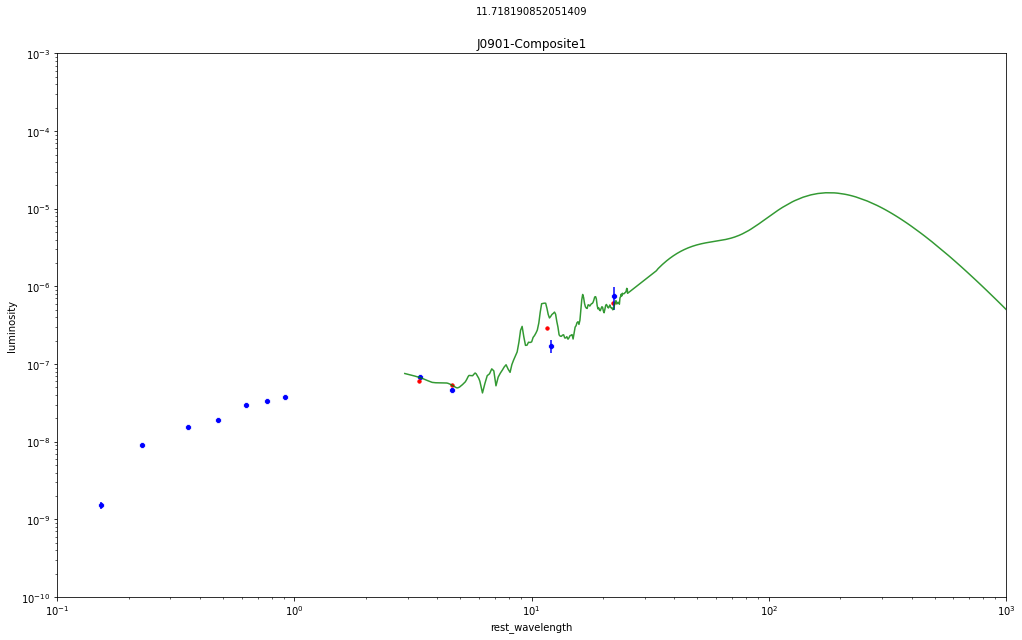

In [71]:
factor1 = fit_template('J0901', 'Composite1')
print(factor1)

In [73]:
with PdfPages('sed_fitting.pdf') as pdf:
    for gal in umeh.index.values:
        print("---Fitting ", gal)
        chis = []
        for tem in templates:
            new_chi = fit_template(gal, tem)
            chis.append(new_chi)
            pdf.savefig(bbox_inches="tight")
            plt.close('all')
        bestchi_pos = chis.index(min(chis))
        print("Galaxy - ", gal, " - lowest chi tempalte: ", templates[bestchi_pos])

---Fitting  J0826
Galaxy -  J0826  - lowest chi tempalte:  IR_COLOR2
---Fitting  J0901
Galaxy -  J0901  - lowest chi tempalte:  SFG1
---Fitting  J0905
Galaxy -  J0905  - lowest chi tempalte:  SFG2
---Fitting  J0944
Galaxy -  J0944  - lowest chi tempalte:  SFG1
---Fitting  J1107
Galaxy -  J1107  - lowest chi tempalte:  SFG3
---Fitting  J1219
Galaxy -  J1219  - lowest chi tempalte:  SFG1
---Fitting  J1341
Galaxy -  J1341  - lowest chi tempalte:  SFG2
---Fitting  J1506
Galaxy -  J1506  - lowest chi tempalte:  SFG2
---Fitting  J1558
Galaxy -  J1558  - lowest chi tempalte:  Composite1
---Fitting  J1613
Galaxy -  J1613  - lowest chi tempalte:  IR_COLOR1
---Fitting  J2116
Galaxy -  J2116  - lowest chi tempalte:  SFG2
---Fitting  J2140
Galaxy -  J2140  - lowest chi tempalte:  SFG3
